Using device: cpu
Training model with init scale σ = 0.01
Training model with init scale σ = 0.1
Training model with init scale σ = 0.5
Training model with init scale σ = 1.0


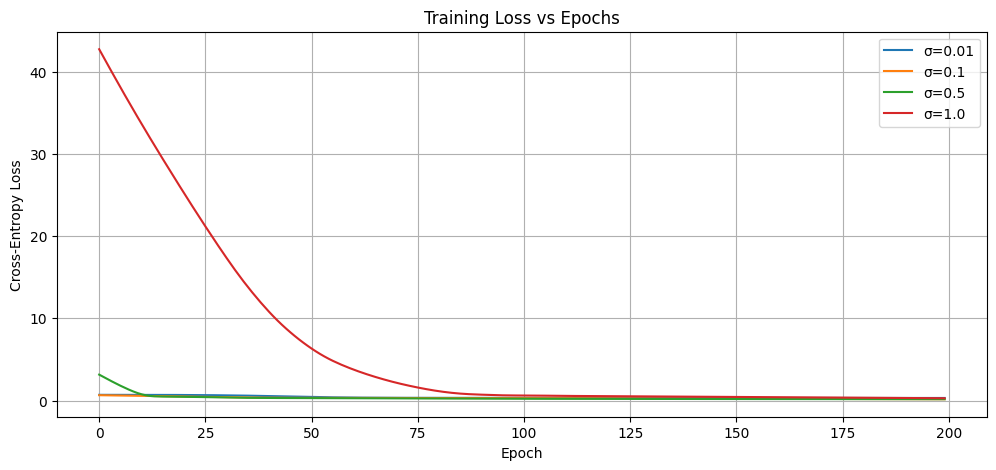

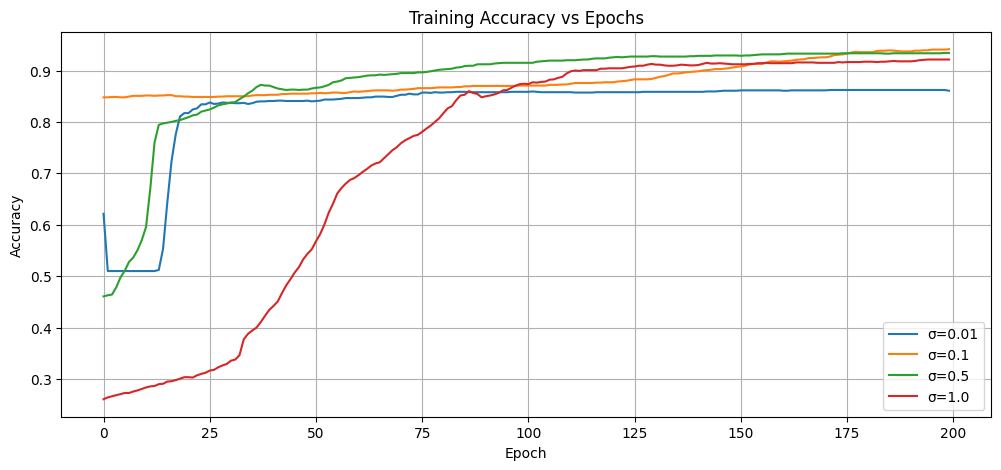

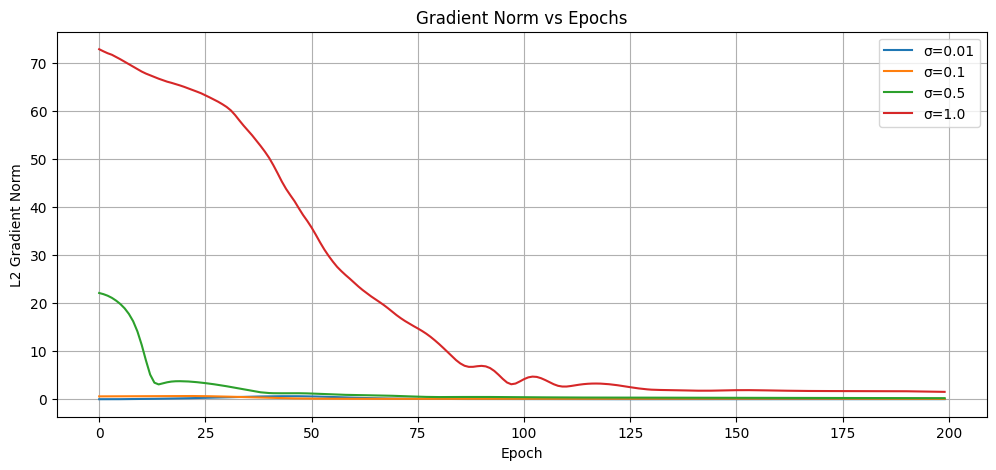

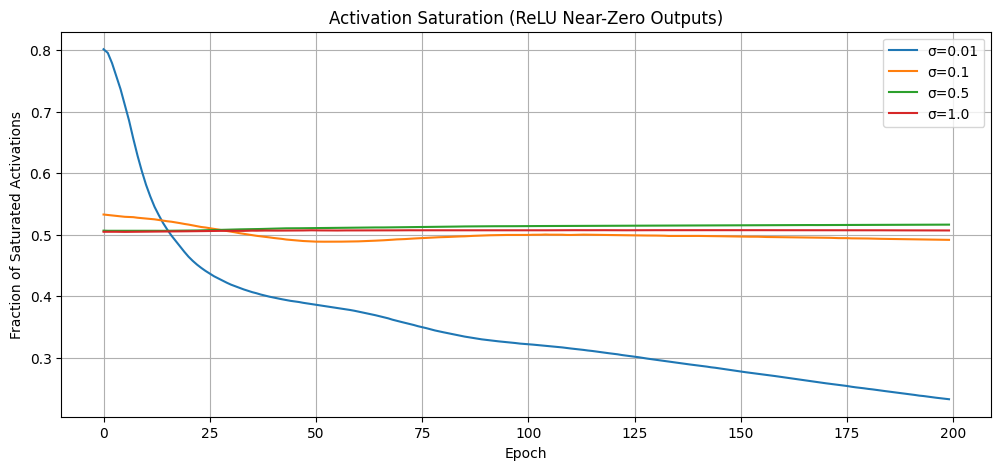


Final Test Accuracies:
σ = 0.01: Test Accuracy = 0.8733
σ = 0.1: Test Accuracy = 0.9483
σ = 0.5: Test Accuracy = 0.9367
σ = 1.0: Test Accuracy = 0.9183


In [1]:
# ---------------------------------------------------------
# Neural Networks: Effect of Weight Initialization Scale on Convergence
# ---------------------------------------------------------
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

device = "cpu"
print("Using device:", device)

# ---------------------------------------------------------
# 1. Dataset (Moons for Visualization)
# ---------------------------------------------------------
X, y = make_moons(n_samples=2000, noise=0.25, random_state=0)
scaler = StandardScaler()
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

X_train = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train = torch.tensor(y_train, dtype=torch.long).to(device)
X_test = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test = torch.tensor(y_test, dtype=torch.long).to(device)

# ---------------------------------------------------------
# 2. Model Definition
# ---------------------------------------------------------
class SimpleNN(nn.Module):
    def __init__(self, init_scale):
        super().__init__()
        self.fc1 = nn.Linear(2, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 2)

        # Manual weight initialization with chosen scale
        for layer in [self.fc1, self.fc2, self.fc3]:
            nn.init.normal_(layer.weight, mean=0.0, std=init_scale)
            nn.init.constant_(layer.bias, 0.0)

    def forward(self, x):
        a1 = F.relu(self.fc1(x))
        a2 = F.relu(self.fc2(a1))
        out = self.fc3(a2)
        return out, a1, a2


# ---------------------------------------------------------
# 3. Train Function
# ---------------------------------------------------------
def train_model(scale):
    model = SimpleNN(scale).to(device)
    optim = torch.optim.Adam(model.parameters(), lr=1e-3)

    losses, accs, grad_norms = [], [], []
    activation_saturation = []

    for epoch in range(200):
        optim.zero_grad()
        logits, a1, a2 = model(X_train)
        loss = F.cross_entropy(logits, y_train)
        loss.backward()

        # Gradient norm
        total_norm = 0
        for p in model.parameters():
            if p.grad is not None:
                total_norm += p.grad.data.norm(2).item()
        grad_norms.append(total_norm)

        optim.step()

        # Record metrics
        preds = logits.argmax(dim=1)
        acc = (preds == y_train).float().mean().item()

        losses.append(loss.item())
        accs.append(acc)

        # Activation saturation (fraction of near-zero neurons)
        saturation = (a1.abs() < 0.01).float().mean().item()
        activation_saturation.append(saturation)

    # Final test accuracy
    with torch.no_grad():
        test_logits, _, _ = model(X_test)
        test_pred = test_logits.argmax(dim=1)
        test_acc = (test_pred == y_test).float().mean().item()

    return {
        "loss": losses,
        "acc": accs,
        "grad": grad_norms,
        "saturation": activation_saturation,
        "test_acc": test_acc,
    }


# ---------------------------------------------------------
# 4. Run Experiments for Different Initialization Scales
# ---------------------------------------------------------
scales = [0.01, 0.1, 0.5, 1.0]
results = {}

for s in scales:
    print(f"Training model with init scale σ = {s}")
    results[s] = train_model(s)

# ---------------------------------------------------------
# 5. Plot Results
# ---------------------------------------------------------
plt.figure(figsize=(12,5))
for s in scales:
    plt.plot(results[s]["loss"], label=f"σ={s}")
plt.title("Training Loss vs Epochs")
plt.xlabel("Epoch")
plt.ylabel("Cross-Entropy Loss")
plt.legend()
plt.grid()
plt.savefig("loss_curves.png")
plt.show()

plt.figure(figsize=(12,5))
for s in scales:
    plt.plot(results[s]["acc"], label=f"σ={s}")
plt.title("Training Accuracy vs Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid()
plt.savefig("accuracy_curves.png")
plt.show()

plt.figure(figsize=(12,5))
for s in scales:
    plt.plot(results[s]["grad"], label=f"σ={s}")
plt.title("Gradient Norm vs Epochs")
plt.xlabel("Epoch")
plt.ylabel("L2 Gradient Norm")
plt.legend()
plt.grid()
plt.savefig("gradient_norms.png")
plt.show()

plt.figure(figsize=(12,5))
for s in scales:
    plt.plot(results[s]["saturation"], label=f"σ={s}")
plt.title("Activation Saturation (ReLU Near-Zero Outputs)")
plt.xlabel("Epoch")
plt.ylabel("Fraction of Saturated Activations")
plt.legend()
plt.grid()
plt.savefig("activation_saturation.png")
plt.show()

# ---------------------------------------------------------
# 6. Print Final Accuracies
# ---------------------------------------------------------
print("\nFinal Test Accuracies:")
for s in scales:
    print(f"σ = {s}: Test Accuracy = {results[s]['test_acc']:.4f}")
